### Usando Tweepy

Para la ejecución de este código necesitarás haber instalado la librería
`tweepy` ([docu](https://docs.tweepy.org/en/stable/client.html)). La ventaja
de usar `tweepy` es el ahorro en el esfuerzo de construir clases para representar
la estructura de datos de Twitter, además de beneficiarnos de los wrappers de
los métodos de adquisición de datos expuestos por Twitter (algunos de los cuales
ya hemos visto en el [tutorial anterior](twitter-api-v2-raw.ipynb)).

Al igual que antes, requeriremos el tener los credenciales en un fichero
`JSON`, de donde los leeremos para la creación de los objetos OAuth:

In [2]:
import tweepy
import json

def get_credentials(file: dict):
    """Reads credential from json file
    :param file: JSON file with CONSUMER and ACCESS TOKE and SECRET values
    :return: dict
    """
    with open(file, "r") as file:
        result = json.load(file)
        return result

creds = get_credentials(file="auth/twitter_credentials.json")

api_v2 = tweepy.Client(
    bearer_token=creds["BEARER_TOKEN"],
    consumer_key=creds["CONSUMER_KEY"],
    consumer_secret=creds["CONSUMER_SECRET"],
    access_token=creds["ACCESS_TOKEN"],
    access_token_secret=creds["ACCESS_SECRET"],
    wait_on_rate_limit=True,
)

Lo primero que podemos hacer es una búsqueda, para así comprobar la sencillez
que ofrece:

In [3]:
query = 'from:suhemparack -is:retweet'
tweet_fields = [
    'author_id',
    'id',
    'context_annotations',
    'created_at',
]
max_results = 10
tweets = api_v2.search_recent_tweets(
    query=query,
    tweet_fields=tweet_fields,
    max_results=max_results,
)
tweets.data

[<Tweet id=1488573858198130690 text=Do you use Twarc from @documentnow for getting data from #TwitterAPI for your research? Join us this Friday to learn from Twitter Developer Insider @IgorBrigadir who is a contributor (and super user) of Twarc to learn how you can get the most out of it 📊 https://t.co/TupdnLCXCB>,
 <Tweet id=1488559232324562945 text=@Cataranea @noamross BTW academic researchers can get data from the full-archive of public Tweets (i.e. older than 7 days) for free Check out 👉https://t.co/xRPnqYBUkV>,
 <Tweet id=1487958483060199433 text=Happy (belated) 1st Birthday to the academic research product track of the #TwitterAPI v2 🎂🎉🥳
 
 Over the last year, researchers have used it to study the conversation around covid, misinformation, polarization and more
 
 How are you using it for your research? https://t.co/uZLQtE3zM1>,
 <Tweet id=1487537194671558657 text=10K downloads for the academictwitteR package 🔥🔥 Well done @justin_ct_ho @cbarrie @chainsawriot 👏👏 https://t.co/O1a1G

Así podemos seguir con la búsqueda de followers:

In [4]:
user_id = "398306220"
max_results = 10
followers = api_v2.get_users_followers(
    id=user_id,
    max_results=max_results
)
followers.data

[<User id=1251562597834358784 name=Mitzy22 username=97Mitzy24>,
 <User id=1488644392252411906 name=Yuriana Marisela Monroy Celedon username=MonroyCeledon>,
 <User id=1488644498045419527 name=Yerai Gómez zoilo username=puladegoma132>,
 <User id=1466489271821426689 name=evan_afton_xd username=54637821739le>,
 <User id=1488639662889525249 name=Stephany username=NailArtistPhany>,
 <User id=1488643298482954241 name=Tomás username=Tomito_T0MI>,
 <User id=1488644422950604800 name=Leonardo GG username=Leonard08052778>,
 <User id=1488643908380811264 name=Valen Baquero username=baquerovalen204>,
 <User id=1488643694295138306 name=AmazingRyder username=amazing_ryder>,
 <User id=1488644456987258881 name=xcan_dyx username=DyxXcan>]

El número máximo por página de resultados (ver [paginación](https://developer.twitter.com/en/docs/twitter-api/pagination))
es 100. Esto significa que si queremos acceder a más de 100 followers, tendremos que de alguna
forma acceder a la siguiente página. Para ello, la API de Tweeter nos devuelve en sus resultados
una parte de `metadata`, donde nos da un token que debemos pasar en la próxima petición.
Trabajando con tweepy, esto se hace de la siguiente forma:

In [5]:
max_items = 10
max_results = 5
tweets = []
for tweet in tweepy.Paginator(
        api_v2.get_users_followers,
        id=user_id,
        max_results=max_results).flatten(limit=max_items):
    tweets += [tweet]

len(tweets)

10

También podemos buscar tweets recientes, como ya hicimos con la API directamente:


In [9]:
query: str = "djokovic -is:retweet lang:en"
tweet_fields = [
    'context_annotations',
    'created_at',
    'author_id',
]
max_results = 10
max_items = 100

tweets = [
    tweet
    for tweet in tweepy.Paginator(
        api_v2.search_recent_tweets,
        query=query,
        tweet_fields=tweet_fields,
        max_results=max_results).flatten(limit=max_items)
]
tweets

[<Tweet id=1488645075903123456 text=@NekoIzNaroda @Sean_Ng818 @Tennis i remember the first time djokovic beat nadal in RG, 2015 the worst nadal ever, just to get smoked by wawrinka in the final 😂 you count that as a title or what? 😂😂>,
 <Tweet id=1488644904695873541 text=@SaadDaw08943502 @pavyg @atptour Are you kidding. Just watching Djokovic you see there’s no plot. He’s just horrible.>,
 <Tweet id=1488644841567232001 text='Had Roger Federer converted match points against Novak Djokovic..' says.. - Tennis World USA https://t.co/MA8A21BpbE>,
 <Tweet id=1488644447730503682 text=@sa_gibson @mandy_facts @cestlaviemacher @Certinfy @Yolitatennis @VintageAddicted Okay, I've tracked down the interview and read it completely. You are right: it appears Djokovic did in fact state he had not been vaccinated on January 6th. This is new information for me.>,
 <Tweet id=1488644346979225600 text=@blane9171 So was Djokovic!!! LOL $TSLAQ>,
 <Tweet id=1488644328608067589 text=#Australian Federal Court's

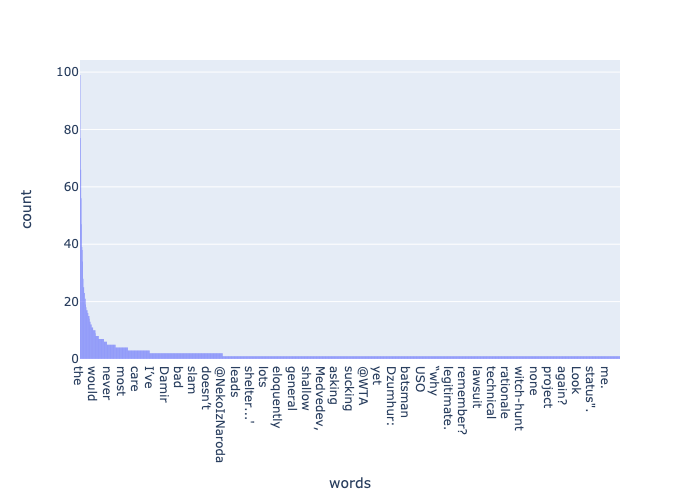

In [10]:
# Replace with your own search query
import pandas as pd
import plotly.express as px

data = [{"date": d.created_at, "text": d.text} for d in tweets]
words = [d["text"].split() for d in data]
words = sum(words, [])

df = pd.DataFrame({"words": words})
fig = px.histogram(df, x="words").update_xaxes(categoryorder="total descending")
fig.show("png")

Otro concepto bastante útil para analítica son los *timelines*, que básicamente
nos permiten acceder a los tweets de un usuario en un intervalo de tiempo:

In [13]:
import datetime

def get_timeline(
        id: str,
        tweet_fields: list,
        max_results: int,
        max_items: int,
        start_time: datetime,
):
    tweets = [
        tweet
        for tweet in tweepy.Paginator(
            api_v2.get_users_tweets,
            id=id,
            start_time=start_time.strftime("%Y-%m-%dT00:00:00+00:00"),
            tweet_fields=tweet_fields,
            max_results=max_results).flatten(limit=max_items)
    ]

    return tweets

timeline = get_timeline(
    id="398306220",
    tweet_fields=[
        "id",
        "created_at",
        "public_metrics",
        "context_annotations",
    ],
    max_results=10,
    max_items=20,
    start_time=(datetime.datetime.now(datetime.timezone.utc)
                - datetime.timedelta(days=7))
)

timeline


[<Tweet id=1488333509005561856 text=@aLexBY11 @bysTaXx ACABA DE TEMBLAR TODA LA CASA WTFFFF>,
 <Tweet id=1487883936198012930 text=Se me ha caido 1 seg pero seguimos vivos 😎🤙>,
 <Tweet id=1487848123192037386 text=MUYAYOS, COMIENZAN LOS SQUID GAMES DE MINECRAFT PARA LOS HACKEADOS, ANDORRANOS Y CAIDOS QUE NO PUDIMOS JUGAR LETS GOOOOO
 
 https://t.co/8ZOxWvmfhQ>,
 <Tweet id=1487614051345707011 text=@AlwaysAlele @LaGranFamiliaDG woah!>,
 <Tweet id=1487614036976021505 text=RT @AlwaysAlele: ⛩️🌺 •◦✦︽  Dojo Rubius  ︽✦◦• 🌺⛩️
 
 ---muchas burgirs🍔 espero q les guste &lt;3 
 // #rubiusfanart #TheGamingFamily // https://t.…>,
 <Tweet id=1487544851210117120 text=RT @vegetta777: RT para que @LaGranFamiliaDG lleve la cocina de nuestros platos a Latino América! @danigarcia_ca @Rubiu5 @WillyrexYT https:…>,
 <Tweet id=1487105301144911876 text=ALGUIEN PUEDE DECIRLE A ESTE HOMBRE QUE ESTOY CASADO? https://t.co/Aiwzi0awXb>,
 <Tweet id=1486872256794009600 text=@JordiWild oleeeeeeeee>,
 <Tweet id=148687190968